In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,applications
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE =256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
  "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
len(dataset) ## we made batch of 32 size total=32*68=2176

131

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 1 1 0 3 0 2 0 2 1 1 3 0 2 0 2 1 0 0 0 2 3 1 0 3 1 0 1 0 1 3 2]


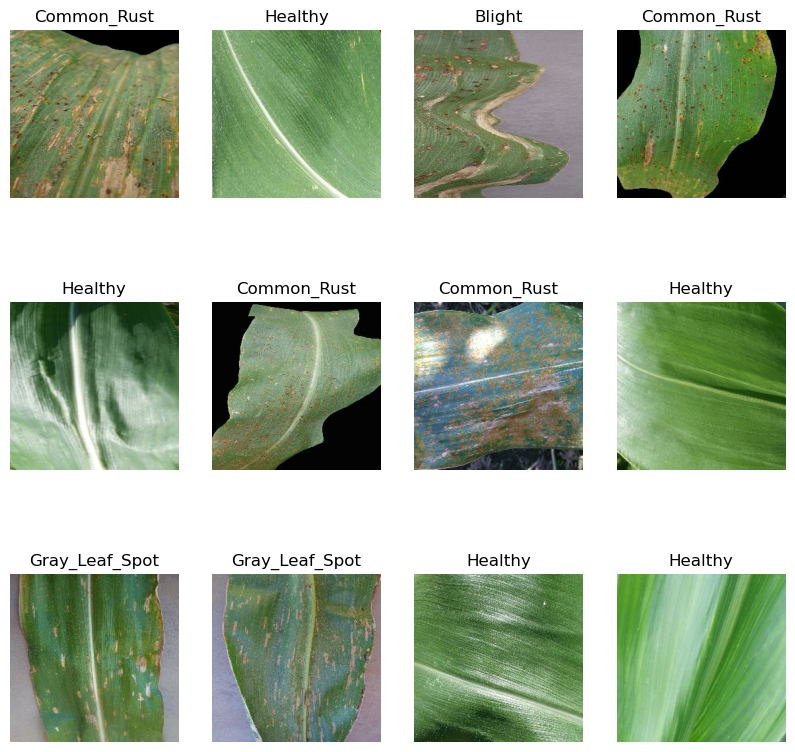

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

131

In [9]:
## we split our data into 80%training and 10%test,10%validation

In [10]:
train_size=0.8
len(dataset)*train_size

104.80000000000001

In [11]:
train_ds=dataset.take(104)
len(train_ds)

104

In [12]:
test_ds=dataset.skip(104)
len(test_ds)

27

In [13]:
val_size=0.1
len(dataset)*val_size

13.100000000000001

In [14]:
val_ds=test_ds.take(13)
len(val_ds)

13

In [15]:
test_ds=test_ds.skip(13)
len(test_ds)

14

In [16]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [18]:
len(train_ds)

104

In [19]:
len(val_ds)

13

In [20]:
len(test_ds)

14

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
##decision tree
from tensorflow.keras.applications import MobileNetV2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [25]:
feature_extractor = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                include_top=False,
                                weights='imagenet',
                                pooling='avg')

In [26]:
def extract_features(dataset):
    features = []
    labels = []
    for image_batch, label_batch in dataset:
        augmented_images = data_augmentation(image_batch)
        processed_images = resize_and_rescale(augmented_images)
        feature_batch = feature_extractor(processed_images)
        features.append(feature_batch.numpy())
        labels.append(label_batch.numpy())
    return np.vstack(features), np.hstack(labels)

In [ ]:
train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)
test_features, test_labels = extract_features(test_ds)

In [28]:
clf = DecisionTreeClassifier()
clf.fit(train_features, train_labels)

DecisionTreeClassifier()

In [29]:
val_predictions = clf.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.8197


In [30]:
test_predictions = clf.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7902


In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf_rf = RandomForestClassifier()
clf_rf.fit(train_features, train_labels)

RandomForestClassifier()

In [33]:
val_predictions_rf = clf_rf.predict(val_features)
val_accuracy_rf = accuracy_score(val_labels, val_predictions_rf)
print(f'Random Forest Validation Accuracy: {val_accuracy_rf:.4f}')

Random Forest Validation Accuracy: 0.9062


In [34]:
test_predictions_rf = clf_rf.predict(test_features)
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print(f'Random Forest Test Accuracy: {test_accuracy_rf:.4f}')

Random Forest Test Accuracy: 0.8862


In [35]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [36]:
rf = RandomForestClassifier()

In [37]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)


In [38]:
rf_random.fit(train_features, train_labels)
print(f'Best hyperparameters: {rf_random.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [39]:
best_rf = rf_random.best_estimator_

In [40]:
val_predictions_rf = best_rf.predict(val_features)
val_accuracy_rf = accuracy_score(val_labels, val_predictions_rf)
print(f'Tuned Random Forest Validation Accuracy: {val_accuracy_rf:.4f}')

Tuned Random Forest Validation Accuracy: 0.9087


In [41]:
test_predictions_rf = best_rf.predict(test_features)
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print(f'Tuned Random Forest Test Accuracy: {test_accuracy_rf:.4f}')

Tuned Random Forest Test Accuracy: 0.8884


In [62]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=4
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])

model.build(input_shape=input_shape)

In [63]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [64]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [65]:
history=model.fit(
     train_ds,
     epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
104/104 [==============================] - 88s 821ms/step - loss: 1.0133 - accuracy: 0.5054 - val_loss: 0.9426 - val_accuracy: 0.5361
Epoch 2/50
104/104 [==============================] - 73s 703ms/step - loss: 0.8841 - accuracy: 0.5683 - val_loss: 0.8005 - val_accuracy: 0.5793
Epoch 3/50
104/104 [==============================] - 72s 696ms/step - loss: 0.6224 - accuracy: 0.7617 - val_loss: 0.4074 - val_accuracy: 0.8149
Epoch 4/50
104/104 [==============================] - 72s 695ms/step - loss: 0.4229 - accuracy: 0.8270 - val_loss: 0.3758 - val_accuracy: 0.8534
Epoch 5/50
104/104 [==============================] - 73s 703ms/step - loss: 0.3749 - accuracy: 0.8412 - val_loss: 0.3126 - val_accuracy: 0.8726
Epoch 6/50
104/104 [==============================] - 73s 703ms/step - loss: 0.3676 - accuracy: 0.8559 - val_loss: 0.2973 - val_accuracy: 0.9087
Epoch 7/50
104/104 [==============================] - 73s 701ms/step - loss: 0.3395 - accuracy: 0.8625 - val_loss: 0.2543 - val_ac

In [66]:
scores=model.evaluate(test_ds)

14/14 [==============================] - 11s 164ms/step - loss: 0.1404 - accuracy: 0.9509


In [67]:
history

In [68]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 104}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

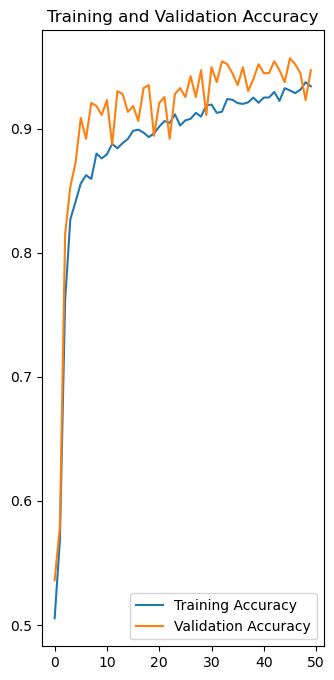

In [71]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation loss')

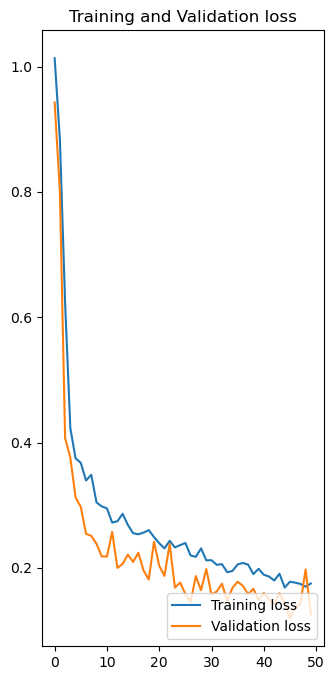

In [72]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

first image to predict
First Image Actual Label: Common_Rust
1/1 [==============================] - 0s 172ms/step
Predicted Label: Common_Rust


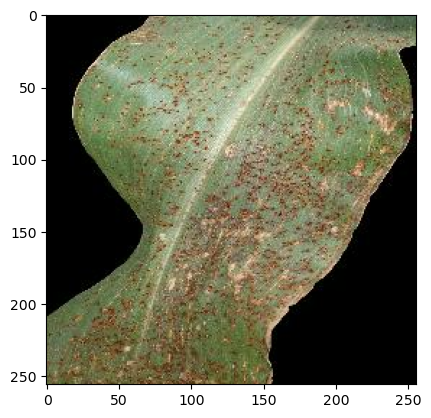

In [75]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=class_names[label_batch[i]]
    print("first image to predict")
    plt.imshow(first_image)
    print("First Image Actual Label:",first_label)
    
    batch_prediction=model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])
    

In [76]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 38ms/step


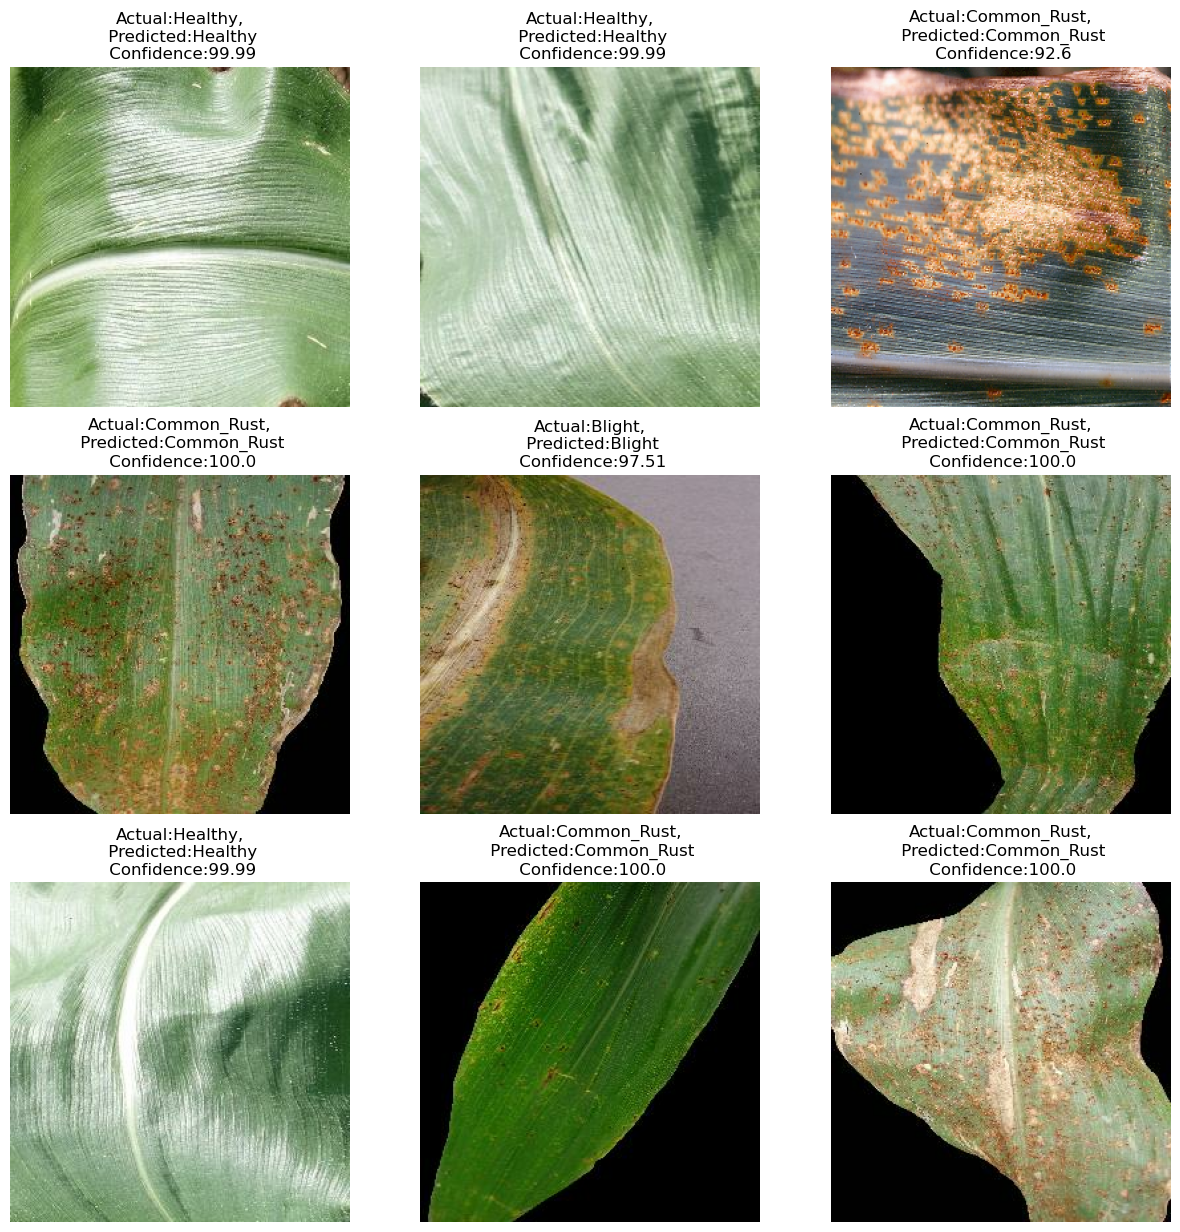

In [77]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}\n Confidence:{confidence}")
        plt.axis("off")

In [24]:
##ResNet50
base_model = applications.ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False

In [25]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


104/104 [==============================] - 219s 2s/step - loss: 0.4075 - accuracy: 0.8397 - val_loss: 0.2058 - val_accuracy: 0.9303
Epoch 2/10
104/104 [==============================] - 198s 2s/step - loss: 0.1817 - accuracy: 0.9305 - val_loss: 0.1711 - val_accuracy: 0.9399
Epoch 3/10
104/104 [==============================] - 260s 3s/step - loss: 0.1461 - accuracy: 0.9474 - val_loss: 0.1487 - val_accuracy: 0.9423
Epoch 4/10
104/104 [==============================] - 259s 2s/step - loss: 0.1280 - accuracy: 0.9534 - val_loss: 0.1312 - val_accuracy: 0.9471
Epoch 5/10
104/104 [==============================] - 394s 2s/step - loss: 0.1061 - accuracy: 0.9630 - val_loss: 0.1694 - val_accuracy: 0.9447
Epoch 6/10
104/104 [==============================] - 211s 2s/step - loss: 0.0958 - accuracy: 0.9678 - val_loss: 0.1113 - val_accuracy: 0.9543
Epoch 7/10
104/104 [==============================] - 204s 2s/step - loss: 0.0910 - accuracy: 0.9675 - val_loss: 0.1055 - val_accuracy: 0.95

In [28]:
scores=model.evaluate(test_ds)

14/14 [==============================] - 33s 2s/step - loss: 0.0835 - accuracy: 0.9732


In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

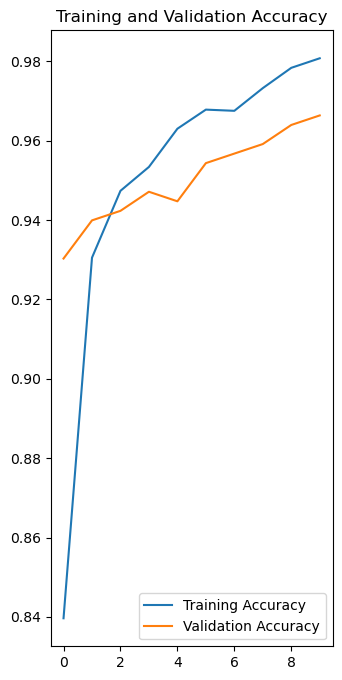

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),acc,label='Training Accuracy')
plt.plot(range(10),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation loss')

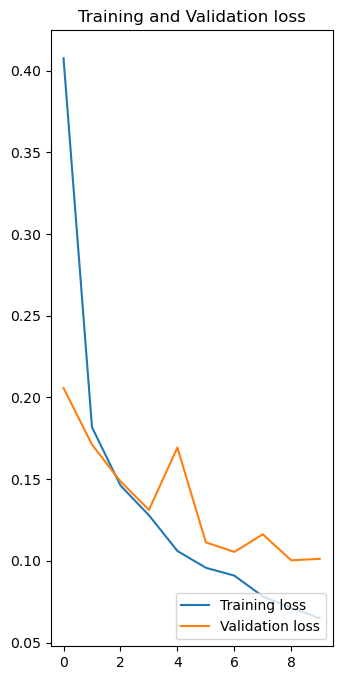

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),loss,label='Training loss')
plt.plot(range(10),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

first image to predict
First Image Actual Label: Common_Rust
1/1 [==============================] - 2s 2s/step
Predicted Label: Common_Rust


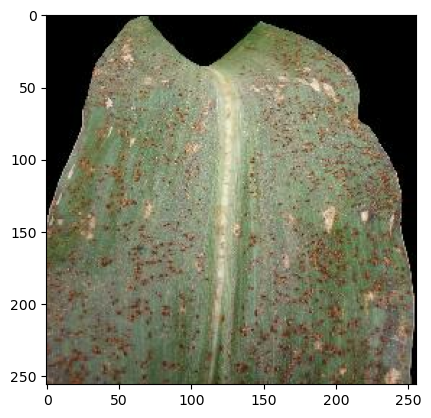

In [31]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=class_names[label_batch[i]]
    print("first image to predict")
    plt.imshow(first_image)
    print("First Image Actual Label:",first_label)
    
    batch_prediction=model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])
    

In [36]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [37]:
base_model.trainable = False

In [38]:
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(256, activation='relu')
output_layer = layers.Dense(len(class_names), activation='softmax')


In [39]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    flatten_layer,
    dense_layer,
    output_layer
])

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=3)

Epoch 1/3
104/104 [==============================] - 6506s 63s/step - loss: 1.0546 - accuracy: 0.7837 - val_loss: 0.3336 - val_accuracy: 0.8750
Epoch 2/3
104/104 [==============================] - 445s 4s/step - loss: 0.3049 - accuracy: 0.8809 - val_loss: 0.4219 - val_accuracy: 0.8558
Epoch 3/3
104/104 [==============================] - 687s 7s/step - loss: 0.2866 - accuracy: 0.8932 - val_loss: 0.2862 - val_accuracy: 0.8942


In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=class_names[label_batch[i]]
    print("first image to predict")
    plt.imshow(first_image)
    print("First Image Actual Label:",first_label)
    
    batch_prediction=model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])
    